In [3]:
import numpy as np
from timeit import default_timer as timer
from numba import njit
from matplotlib import pyplot as plt
from numba.typed import List
%matplotlib inline

In [4]:
def write_frame(fh,pos,edgelength):
 
    n = np.shape(pos)[0]
    fh.write('{}\n'.format(n))
    
    fh.write('{:8.7g}\n'.format(iteration))
    for i in range(len(pos[::2])):
        fh.write('LJ1 {:12.6g} {:12.6g} {:12.6g}\n'.format(pos[::2,0][i]%edgelength, pos[::2,1][i]%edgelength, pos[::2,2][i]%edgelength))
        if len(pos)%2!=0 and i == len(pos[::2]):
            break 
        else: fh.write('LJ2 {:12.6g} {:12.6g} {:12.6g}\n'.format(pos[1::2,0][i]%edgelength, pos[1::2,1][i]%edgelength, pos[1::2,2][i]%edgelength))
    return

def generate_lattice(pos,density):

    # set initial coordinates of atoms at fcc lattice sites

    # pos     - array that will return atom positions
    # T       - temperature fixed to
    # density - number density of simulation cell
    # n       - number of atoms in simulation cell (extracted from dimensions of pos)
    # n_cells - number of unit cells/edgelength
    # L_cell  - edgelength of fcc unit cell
    # offset  - components giving vector offsets of atom positions from cell corner
    # r_base  - components of corner of unit cell currently being used for atom placement
    
    n = np.shape(pos)[0]
    tmp = np.float_power(n/4,1/3)
    n_cells = int(np.ceil(tmp))

    L_cell = np.float_power(n/rho,(1/3))/n_cells
    offset = np.array([[0,0,0],[L_cell/2,L_cell/2,0],[L_cell/2,0,L_cell/2],[0,L_cell/2,L_cell/2]])
    atom_count = 0
    for ix in range(n_cells):
        for iy in range(n_cells):
            for iz in range(n_cells):
                r_base = np.array([ix,iy,iz])
                r_base = r_base*L_cell
                for site in range(4):
                    if atom_count < n_atoms:
                        pos[atom_count,:] = r_base + offset[site,:]
                        atom_count = atom_count + 1
    return pos

#odd is atom type 2, even is atom type 1
#atom 0 is going to be type 1
#type 1 - type 1 will be sigma=1 epsilon=1
#factor a and factor b will scale epsilon and sigma respectively for particle type 2 - type 2 interaction
#factor c and d will scale epsilon and sigma respectively for particle type 1 - type 2 interaction
@njit
def LJCalc(r,atomindex,edgelength,r_cutoff_2,a,b,c,d):  
    v=0   
    #for even atomindex
    if atomindex%2==0:
            #type 1 to type 1
            for i in range(len(r[::2])):
                if i*2 !=atomindex:
                    r_ij=r[atomindex,:] - r[::2,:][i]

                    r_ij -= edgelength*np.rint(r_ij/edgelength)
                    r_ij_2=np.dot(r_ij,r_ij)
                    if r_ij_2<r_cutoff_2:
                        inv_r_ij_6=1/(r_ij_2**3)

                        v += 4*((inv_r_ij_6**2)-(inv_r_ij_6))
            #type 1 to type 2
            for i in range (len(r[1::2])):
                r_ij=r[atomindex,:] - r[1::2,:][i]

                r_ij -= edgelength*np.rint(r_ij/edgelength)
                r_ij_2=np.dot(r_ij,r_ij)
                if r_ij_2<r_cutoff_2:
                    dinv_r_ij_6=(d**2/r_ij_2)**3

                    v += 4*c*((dinv_r_ij_6**2)-(dinv_r_ij_6))
    #for odd atom index
    else:
            #type 2 to type 1 
            for i in range(len(r[::2])):
                r_ij=r[atomindex,:] - r[::2,:][i]

                r_ij -= edgelength*np.rint(r_ij/edgelength)
                r_ij_2=np.dot(r_ij,r_ij)
                if r_ij_2<r_cutoff_2:
                    dinv_r_ij_6=(d**2/r_ij_2)**3

                    v += 4*c*((dinv_r_ij_6**2)-(dinv_r_ij_6))
            #type 2 to type 2
            for i in range (len(r[1::2])):
                if i*2+1 !=atomindex:
        
                    r_ij=r[atomindex,:] - r[1::2,:][i]
                    r_ij -= edgelength*np.rint(r_ij/edgelength)
                    r_ij_2=np.dot(r_ij,r_ij)
        
                    if r_ij_2<r_cutoff_2:
                        binv_r_ij_6=(b**2/r_ij_2)**3

                        v += 4*a*((binv_r_ij_6**2)-(binv_r_ij_6))
            
    return v


@njit
def analysis_loop(n,edgelength,r_cutoff_2,n_bin,pos):
    #
    #  calculate potential energy, virial and hypervirial functions
    #  accumulate radial distribution function
    #
    V = 0
    W = 0
    X = 0
    g_r = np.zeros(n_bin)
    delta_r = edgelength/2/n_bin
    
    #Type 1 type 1
    for i in range(len(pos[::2])-1):
        for j in range(i+1,len(pos[::2])):
            r_ij = pos[::2,:][i] - pos[::2,:][j]
            r_ij -= edgelength*np.rint(r_ij/edgelength) # apply PBC
            r_ij_2 = np.dot(r_ij,r_ij)
            inv_r_ij_6 = 1/(r_ij_2**3)
            V += 4*inv_r_ij_6*( inv_r_ij_6 - 1 )
            W += -24*inv_r_ij_6*( 2*inv_r_ij_6 - 1 )
            X += 144*inv_r_ij_6*( 4*inv_r_ij_6 - 1 )
            # add radial distance to radial distribution function count array
            r_index = int(np.sqrt(r_ij_2)/delta_r)
            if r_index < n_bin: 
                g_r[r_index] += 2
                
    #Type 1 to type 2            
    for i in range(len(pos[::2])):
        for j in range(len(pos[1::2])):
            r_ij = pos[::2,:][i] - pos[1::2,:][j]
            r_ij -= edgelength*np.rint(r_ij/edgelength) # apply PBC
            r_ij_2 = np.dot(r_ij,r_ij)
            inv_r_ij_6 = 1/(r_ij_2**3)
            V += 4*c*(d**6 * inv_r_ij_6)*( (d**6 *inv_r_ij_6) - 1 )
            W += -24*c*(d**6*inv_r_ij_6)*( 2*(d**6*inv_r_ij_6) - 1 )
            X += 144*c*(d**6*inv_r_ij_6)*( 4*(d**6*inv_r_ij_6) - 1 )
            # add radial distance to radial distribution function count array
            r_index = int(np.sqrt(r_ij_2)/delta_r)
            if r_index < n_bin:
                g_r[r_index] += 2
                
    #type 2 to type 2           
    for i in range(len(pos[1::2])-1):
        for j in range(i+1,len(pos[1::2])):
            r_ij = pos[1::2,:][i] - pos[1::2,:][j]
            r_ij -= edgelength*np.rint(r_ij/edgelength) # apply PBC
            r_ij_2 = np.dot(r_ij,r_ij)
            inv_r_ij_6 = 1/(r_ij_2**3)
            V += 4*a*(b**6 * inv_r_ij_6)*( (b**6 *inv_r_ij_6) - 1 )
            W += -24*a*(b**6*inv_r_ij_6)*( 2*(b**6*inv_r_ij_6) - 1 )
            X += 144*a*(b**6*inv_r_ij_6)*( 4*(b**6*inv_r_ij_6) - 1 )
            # add radial distance to radial distribution function count array
            r_index = int(np.sqrt(r_ij_2)/delta_r)
            if r_index < n_bin:
                g_r[r_index] += 2
                
    return V, W, X, g_r 

def read_frame(fh,iteration,pos):
    #
    # read coordinates and velocities at time from datafile using XYZ file format
    # (see Wikipedia page "XYZ File Format" for details)
    #
    # n_atoms
    # time
    # "He" x_i y_i z_i vx_i vy_i vz_i (repeated for each atom i - Note: He can be any element)
    #
    # current_time - time read from file (defined as array in calling function so we can pass back - HACK!!)
    # fh           - filehandle for open file (appropriate file needs to be already opened for reading)
    # pos          - array holding particle positions
    # vel          - array holding particle velocities
    # n            - number of atoms (determined from array shape of pos)
    # success      - whether read was successful - function flags the end of a file with success = false
    
    n = np.shape(pos)[0]

    success = False
    data = fh.readline()
    
    # check to make sure we aren't at the end of a file by ensuring first read value is non-empty
    
    if data != "":
        n_in_file = int(data)
        # check whether number in the file is the same as the number of atoms as determined by the arrays
        if n_in_file != n:
            print("Error: Number of atoms written in file, ",n_in_file," differs from n_atoms of ",n)
        iteration[0] = float(fh.readline())
        for i in range(n):
            data = fh.readline()
            values = data.split()
            pos[i,:] = [float(values[1]), float(values[2]), float(values[3])]
        success = True
    return success
def calculate_trans_order(edgelength,n,pos):
    #
    # calculate translational order parameter
    #
    # edgelength - edgelength of the fcc lattice unit cell
    # n          - number of atoms
    # pos        - positions of the atoms
    #

    k_vec = np.array([-1.0,1.0,-1.0],dtype=np.float64)
    k_vec = 2*np.pi/edgelength*k_vec

    trans_order = 0
    for i in range(n):
        trans_order += np.cos(np.dot(k_vec,pos[i,:]))

    return trans_order/n

In [82]:
n_atoms=500
T=2.2
rho =0.01
pos=np.empty((n_atoms,3))
n=np.shape(pos)[0]

Volume = n_atoms/rho
L = np.float_power(Volume,(1/3))

d_rmaxratio=0.05
d_rmax=L*d_rmaxratio

runs=200000

r_cutoff = 7
#type 2- type 2 interactions
#epsilon
a=5
#sigma
b=1

#type 1 - type 2 interactions
#epsilon
c=0.1
#sigma
d=1

d_rmaxoverride= False
trajfile = 'traj.xyz'
how_to_initialize = "equilibrating"
initfile = "last_frame.xyz"
iteration=0

if how_to_initialize == "lattice":
    generate_lattice(pos,rho)
#debugging purposes   
    print("Initial configuration generated on fcc lattice")
elif how_to_initialize == "file":
    inputfile = open(initfile, "r")
    tmp = [0]
    read_frame(inputfile,tmp,pos)
    inputfile.close()
    time = 0
    print("Initial state read from file", initfile)
    
elif how_to_initialize == "restart":
    d_rmaxoverride=False
    d_rmax=saved_d_rmax
    inputfile = open(trajfile, "r")
    frame_count = 0
    tmp = [0]
    while read_frame(inputfile,tmp,pos):
        frame_count += 1
    inputfile.close()
    iteration = tmp[0]
    print("Read", frame_count, "frames from trajectory file", trajfile)
    print("Restarting trajectory at iteration", iteration)

elif how_to_initialize == "equilibrating":
    inputfile = open(initfile, "r")
    tmp = [0]
    read_frame(inputfile,tmp,pos)
    inputfile.close()
    time = 0
    print("Initial state read from file, Equilibrated", initfile)
    d_rmax=saved_d_rmax
    print("debug value {}".format(d_rmax))
#Debugging purposes
elif how_to_initialize == "speedup":
    inputfile = open(initfile, "r")
    tmp = [0]
    read_frame(inputfile,tmp,pos)
    inputfile.close()
    time = 0
    print("Initial state read from file, Equilibrated", initfile)
    d_rmaxoverride=True
    d_rmax=0.22
    print("debug value {}".format(d_rmax))



if how_to_initialize != "restart":
    outputfile = open(trajfile, "w")
    write_frame(outputfile,pos,L)
    outputfile.close()

outputfile=open('traj.xyz','a')

failed=0
failratio=0



if r_cutoff > L/2:
    r_cutoff = L/2
    print("Cutoff distance reset to {}".format(r_cutoff))
r_cutoff_squared = r_cutoff*r_cutoff
print(pos[1])
start_time = timer()
for i in range(0,runs):
    atomindex=np.random.randint(0,n)
    
    pos_tmp = np.copy(pos)
    
    v_pre = LJCalc(pos_tmp,atomindex,L,r_cutoff_squared,a,b,c,d)
#create move vector
    movevect=np.random.uniform(-d_rmax,d_rmax,3)
    pos_tmp[atomindex] += movevect
    
    v_post=LJCalc(pos_tmp,atomindex,L, r_cutoff_squared,a,b,c,d)
        
  #test which pos to accept.
    if v_post < v_pre:
        pos=pos_tmp
        iteration += 1
        
    else:
      #beta should be = 1 after unit conversions
        d_v=v_post-v_pre
        delta=d_v/T
        zeta=np.random.uniform(0,1)

        if np.exp(-delta)> zeta:
            pos=pos_tmp
            iteration +=1

        else:
            iteration +=1
            failed+=1 
            failratio +=1
        
      #write frequency
    if iteration%1000 == 0 :
        write_frame(outputfile,pos,L)
        
    if iteration%10000 == 0:
        
        if d_rmaxoverride == False:
            if failratio/10000 > 0.55:
                d_rmax=d_rmax*0.9
               
                failratio=0

            elif failratio/10000 < 0.45:
                d_rmax=d_rmax*1.1
         
                failratio = 0
    if d_rmax>L/4:
        d_rmax=L/4
        
    if (i+1)%25000 == 0: 
        print("completed {} iterations".format(i+1))
        print('d_rmax currently adjusted to {}'.format(d_rmax))
        
outputfile.close()
print('move ratio:{}'.format(1-(failed/iteration)))
saved_d_rmax=d_rmax

openfile=open('last_frame.xyz','w')
write_frame(openfile,pos,L)
openfile.close()
end_time = timer()
print("\nPropagation took {:g} minutes.".format( (end_time-start_time)/60))
print("a, b, c, d = {}, {}, {}, {}" .format(a, b, c, d))

Initial state read from file, Equilibriated last_frame.xyz
debug value 9.210078746600965
[25.4585   4.18096  8.82836]
completed 25000 iterations
d_rmax currently adjusted to 9.210078746600965
completed 50000 iterations
d_rmax currently adjusted to 9.210078746600965
completed 75000 iterations
d_rmax currently adjusted to 9.210078746600965
completed 100000 iterations
d_rmax currently adjusted to 9.210078746600965
completed 125000 iterations
d_rmax currently adjusted to 9.210078746600965
completed 150000 iterations
d_rmax currently adjusted to 9.210078746600965
completed 175000 iterations
d_rmax currently adjusted to 9.210078746600965
completed 200000 iterations
d_rmax currently adjusted to 9.210078746600965
move ratio:0.849195

Propagation took 0.771896 minutes.
a, b, c, d = 5, 1, 0.1, 1


In [83]:
# define parameters for translational order parameter
#
start_time = timer()
n_cells = int(np.ceil(np.float_power(n_atoms/4,1/3)))
L_cell = L/n_cells
trans_order = np.empty((0))

# define parameters for radial distribution function
#
#  n_bin_r - number of bins in radial direction
#  g_r_t   - radial distribution function as a function of time 
#  bin_r   - holds radial distance values situated at the midpoints of the radial grid

n_bin_r = 500
r_max = L/2
dr = r_max/n_bin_r
g_r_t = np.empty((0,n_bin_r))
bin_r = np.arange(0,n_bin_r,1)
bin_r = bin_r*dr + 0.5*dr  # scale and shift grid to midpoints

#  define arrays for holding time dependent quantities
#
#  K_t  - kinetic energy per atom
#  V_t  - potential energy per atom
#  W_t  - virial function
#  X_t  - hypervirial function (chi)


K_t = np.empty((0))
V_t = np.empty((0))
W_t = np.empty((0))
X_t = np.empty((0))


inputfile = open('traj.xyz', "r")
frame_count = 0
tmp = [0]
while read_frame(inputfile,tmp,pos):
    trans_order = np.append(trans_order,calculate_trans_order(L_cell,n_atoms,pos))

    V_tmp, W_tmp, X_tmp, g_r_tmp = analysis_loop(n_atoms,L,r_cutoff_squared,n_bin_r,pos)

    V_t = np.append(V_t,V_tmp/n_atoms)
    W_t = np.append(W_t,W_tmp)
    X_t = np.append(X_t,X_tmp)
    g_r_tmp = g_r_tmp/( 4*np.pi*rho*n_atoms*bin_r*bin_r*dr ) #normalize g(r)
    g_r_t = np.append(g_r_t,[g_r_tmp],axis=0)
    frame_count += 1

inputfile.close()
end_time = timer()
print("\nAnalysis took {:g} minutes.".format( (end_time-start_time)/60))


Analysis took 0.101515 minutes.


In [84]:
K_t =  1.5*T
T_t = 2/3*n_atoms/(n_atoms-1)*K_t
P_t = rho*T + W_t/Volume
V_ave = np.mean(V_t)
E_ave = V_ave + K_t


P_ave = np.mean(P_t)
PV_ave = np.mean(P_t*V_t)


print(np.shape(V_t))


V_var=np.var(V_t)

P_var = np.var(P_t)
PV_var = PV_ave - P_ave*V_ave




print("\nAverages and Variances\n")
print("< E > = ", E_ave)
#"< Delta E^2 > = ", E_var)
print("< V > = ", V_ave, "< Delta V^2 > = ", V_var)
print("< K > = ", K_t)
print("< T > = ", T)
print("< P > = ", P_ave, "< Delta P^2 > = ", P_var)
print("< PV > = ", PV_ave, "< Delta P Delta V > = ", PV_var)
print("< PK > = ", P_ave * K_t)
#print(np.max(V_t))

# calculate some thermodynamic quantities
# C_V     - molar heat capacity / R
# gamma_V - thermal pressure
# beta_T  - isothermal compressibility
# alpha   - coefficient of thermal expansion


C_V = 1.5 + (n_atoms*V_var)/((T**2))

tmp=PV_var
gamma_V = (tmp/(T**2)) + rho


tmp=np.average(X_t)
inv_beta_T = (-Volume*P_var/T) + 3*n_atoms/(3*Volume) + P_ave + tmp/Volume
beta_T= 1/inv_beta_T

alpha = beta_T*gamma_V

print("\nThermodynamic Quantities\n")
print("C_V,m/R = ",C_V)
print("beta_T = ",beta_T)
print("gamma_V = ",gamma_V)
print("PV/NkT = ",P_ave/rho/T)
print("alpha = ",alpha)

print('\n Maximum change in distance\n')
print(d_rmax)

(201,)

Averages and Variances

< E > =  3.216542115741632
< V > =  -0.08345788425836846 < Delta V^2 > =  0.0016336514168254679
< K > =  3.3000000000000003
< T > =  2.2
< P > =  0.01940279010181039 < Delta P^2 > =  2.947891300718297e-05
< PV > =  -0.0018193773048565435 < Delta P Delta V > =  -0.00020006149425023478
< PK > =  0.0640292073359743

Thermodynamic Quantities

C_V,m/R =  1.668765642234036
beta_T =  -1.8735957961029097
gamma_V =  0.009958664980526812
PV/NkT =  0.8819450046277449
alpha =  -0.0186585128423123

 Maximum change in distance

9.210078746600965


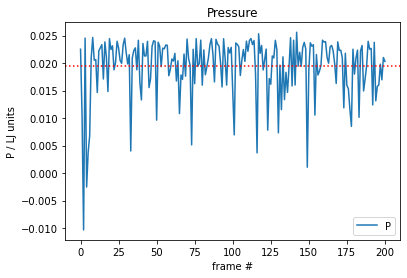

In [89]:
#pressure graph
plt.plot(P_t,label="P")
plt.xlabel("frame #")
plt.ylabel("P / LJ units")
plt.axhline(y=P_ave,color='r',ls=':')
plt.title('Pressure')
plt.legend()
plt.show()

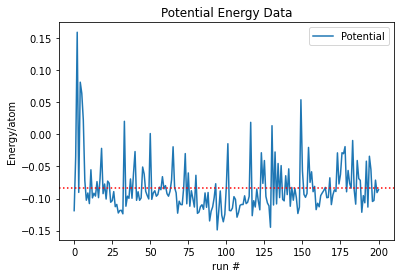

In [88]:
#Potential energy graph
plt.plot(V_t,label="Potential")

plt.axhline(y=V_ave,color='r',ls=':')

plt.xlabel("run #")
plt.ylabel("Energy/atom")
plt.title('Potential Energy Data')
plt.legend()
plt.show()

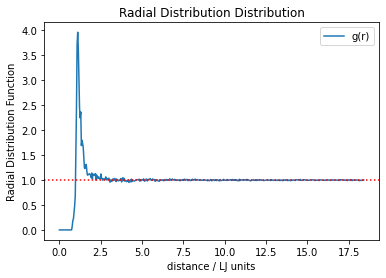

1.1236296070853178


In [86]:
# construct average radial distribution function over time

g_r = np.mean(g_r_t,axis=0)

plt.plot(bin_r,g_r,label="g(r)")
plt.xlabel("distance / LJ units")
plt.ylabel("Radial Distribution Function")
plt.legend()
plt.title('Radial Distribution Distribution')
plt.axhline(y=1,color='r',ls=':')
#plt.ylim(0.7,3.7)
#plt.xlim(0,5)
#plt.ylim(0,2)
plt.show()

# distance at highest radial distribution
print(bin_r[np.argmax(g_r)])

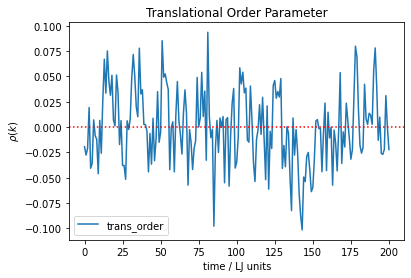

In [87]:
plt.plot(trans_order,label="trans_order")
plt.xlabel("time / LJ units")
plt.ylabel(r"$\rho(k)$")
plt.axhline(y=0,color='r',ls=':')
plt.title('Translational Order Parameter')
plt.legend()
plt.show()